## Impact Of Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt,matplotlib.ticker as mticker
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torchvision import datasets
device='cuda' if torch.cuda.is_available() else 'cpu'
fmnist=datasets.FashionMNIST(r'../data',download=True,train=True)
val_fmnist=datasets.FashionMNIST(r'../data',download=True,train=False)
tr_images=fmnist.data
tr_targets=fmnist.targets
val_images=val_fmnist.data
val_targets=val_fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        self.x,self.y=x.float().view(-1,28*28)/255,y
    def __getitem__(self, item):
        return self.x[item].to(device),self.y[item].to(device)
    def __len__(self):
        return len(self.x)

def get_model():
    model=nn.Sequential(
        nn.Linear(28*28,1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)
    loss_fn=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction=model(x)
    max_values,argmaxes=prediction.max(-1)
    is_correct=argmaxes==y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train=FMNISTDataset(tr_images,tr_targets)
    trn_dl=DataLoader(train,batch_size=32,shuffle=True)
    val=FMNISTDataset(val_images,val_targets)
    val_dl=DataLoader(val,batch_size=len(val_images),shuffle=False)
    return trn_dl,val_dl

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
    model.eval()
    val_loss=loss_fn(model(x),y)
    return val_loss.item()

In [3]:
trn_dl,val_dl=get_data()
model,loss_fn,optimizer=get_model()

In [4]:
train_losses,train_accuracies=[],[]
val_losses,val_accuracies=[],[]
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


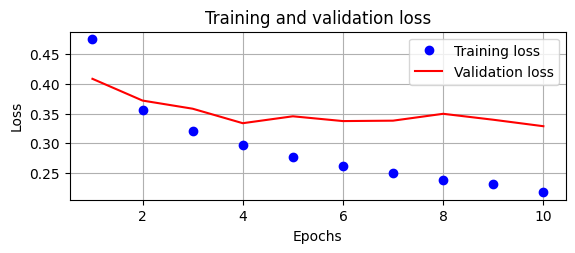

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23912\2392713454.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


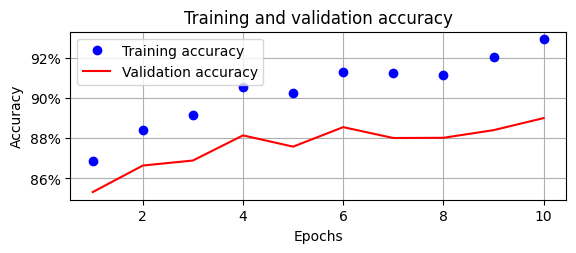

In [5]:
epochs = np.arange(10)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

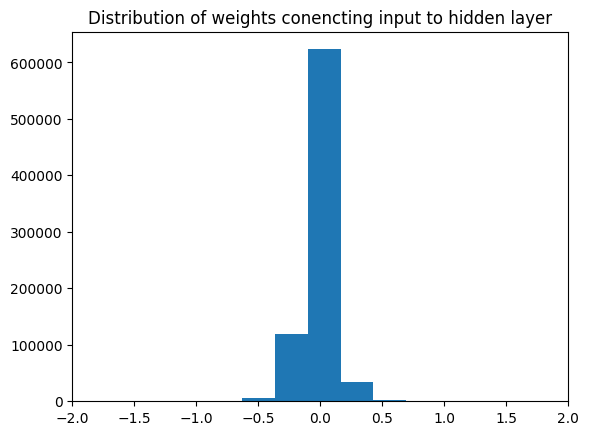

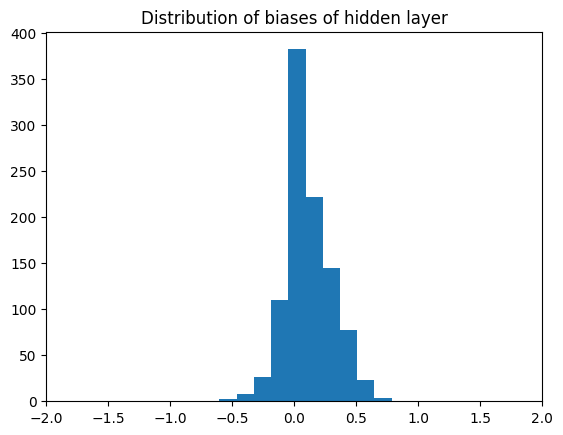

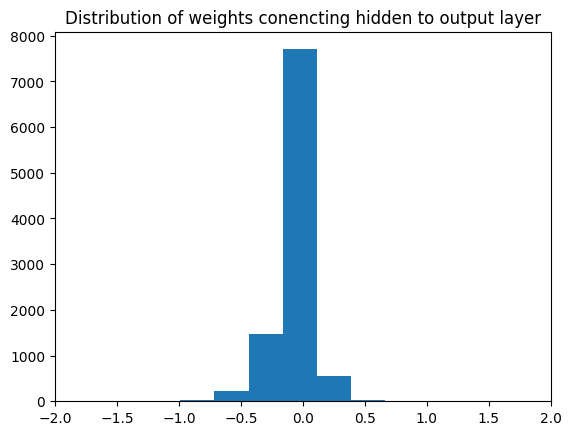

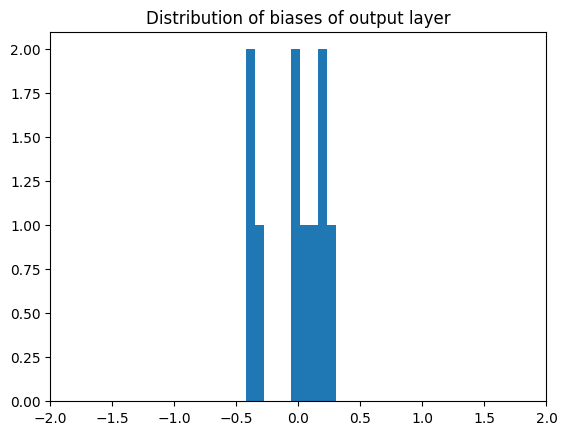

In [6]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show() 

In [7]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    l1_regularization=0
    for param in model.parameters():
        l1_regularization+=torch.norm(param,1)
    batch_loss=loss_fn(model(x),y)+0.000*l1_regularization
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


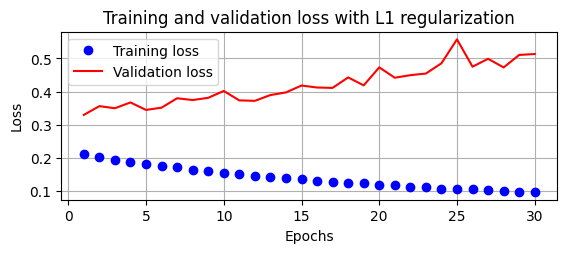

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23912\3036444862.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


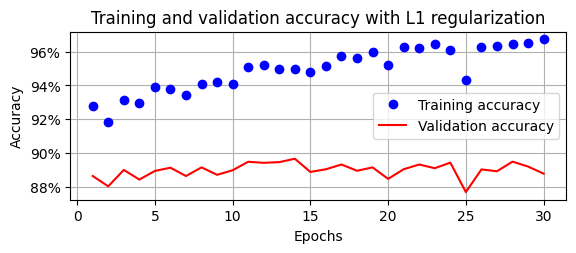

In [9]:
epochs = np.arange(30)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

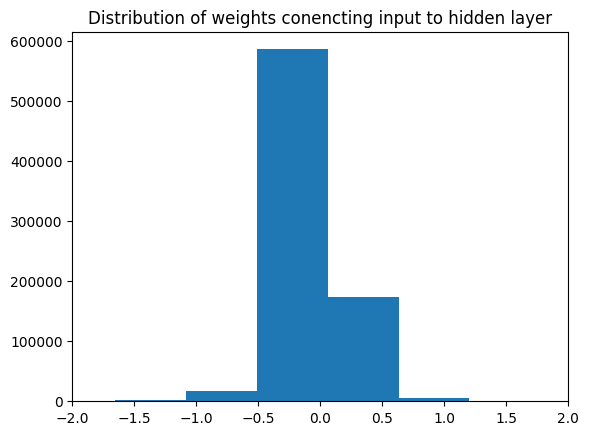

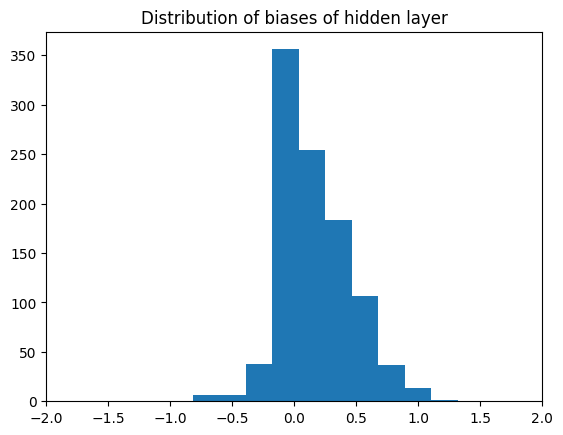

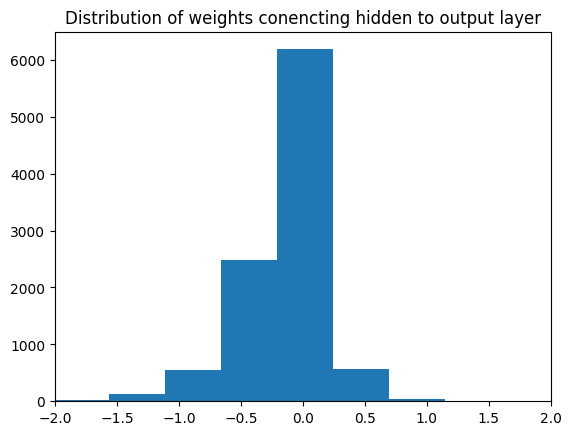

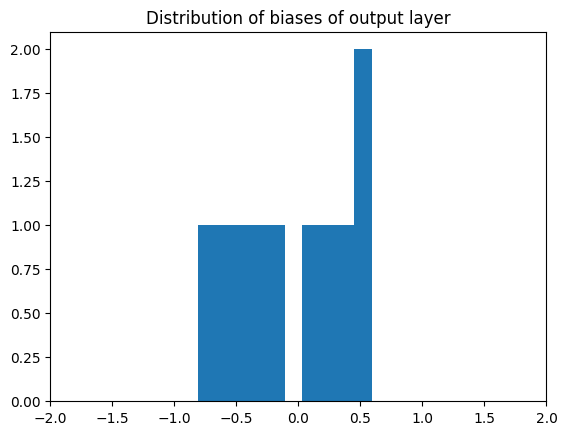

In [10]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()

In [11]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    l2_regularization = 0
    for param in model.parameters():
      l2_regularization += torch.norm(param,2)
    batch_loss = loss_fn(model(x), y) + 0.01*l2_regularization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3


In [ ]:
epochs = np.arange(30)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()  